# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Libraries

In [2]:
!pip install nltk
!pip install bert-tensorflow
!pip install transformers
!pip install seaborn
!pip install sklearn-crfsuite
!pip install -U sentence-transformers
import nltk
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 890kB 5.0MB/s 
     |████████████████████████████████| 3.0MB 18.2MB/s 
     |████████████████████████████████| 1.1MB 24.7MB/s 
     |████████████████████████████████| 890kB 37.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1fe9de6443eafe4ff32499488848e533edecf63fbad8a32f336a6141be4524f6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 747kB 8.3MB/s 
     |████████████████████████████████| 71kB 4.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.6-cp36-none-any.whl size=101182 sha256=e7754e00a7098ca96beb5e28e65066cb19347bf4d43d5208e72ec677aa658e24
  Stored in directory: /root/.cache/pip/wheels/6f/3f/75/c0c4b3ef5dfbf8806d37b8dc661861772aba2f7aa419c85a9b
Successfully built sentence

True

# Get imports

- **General:** random, pickle, re, time, datetime
- **General DS:** pandas, numpy, sklearn, matplotlib, seaborn, nltk
- **Deep Learning:** torch, transformers

In [38]:
import random
import pickle
import re
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer

# GPU device Setup

In [4]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Dataset loading

In [11]:
DATASET_ROOT = '/content/drive/My Drive/HASOC/Data/2020_processed_data/'

In [12]:
with open(DATASET_ROOT+'ge.pickle', 'rb') as f:
  ged = pickle.load(f)

Checking it once for content description

In [ ]:
ged.keys()

dict_keys(['tweet_id', 'task_1', 'task_2', 'hasoc_id', 'full_tweet', 'tweet_raw_text', 'hashtags', 'smiley', 'emoji', 'url', 'mentions', 'numerals', 'reserved_word', 'emotext', 'segmented_hash'])

In [ ]:
ged['task_1'][:10]

['NOT', 'NOT', 'NOT', 'NOT', 'HOF', 'HOF', 'NOT', 'NOT', 'HOF', 'NOT']

## Split data into train-test-val

In [ ]:
train1_hash = ged['segmented_hash'][:2000]
test1_hash = ged['segmented_hash'][2000:]

In [ ]:
train_hash = []
for lis in train1_hash:
  train_hash.append(' '.join(lis))
test_hash = []
for lis in test1_hash:
  test_hash.append(' '.join(lis))

In [ ]:
train_text, test_text, train_t1s, test_t1s = model_selection.train_test_split(
    ged['tweet_raw_text'],
    ged['task_1'],
    test_size = 0.2,
    # random_state = 42
)

In [ ]:
train_text = ged['tweet_raw_text'][:2000]
train_t1s = ged['task_1'][:2000]

test_text = ged['tweet_raw_text'][2000:]
test_t1s = ged['task_1'][2000:]

# get Functions

In [14]:
def get_features(embeddings):
  # emb = []
  # for e in embeddings:
  #   emb.append({'feat': e})
  emb = embeddings
  return emb

In [15]:
def get_task(tasklist):
  newtasks = []
  for x in tasklist:
    if x == 'NOT':
      # newtasks.append(['0'])
      newtasks.append(0)
    else:
      # newtasks.append(['1'])
      newtasks.append(1)
  return newtasks

# Experiment: Sentence Embeddings, xlm-r-100langs-bert-base-nli-mean-tokens

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-dbmdz-uncased', do_lower_case=True)
sent_encoder = SentenceTransformer('xlm-r-100langs-bert-base-nli-mean-tokens')

100%|██████████| 1.01G/1.01G [00:20<00:00, 48.6MB/s]


In [ ]:
train_embeddings = sent_encoder.encode(train_text)

In [ ]:
test_embeddings = sent_encoder.encode(test_text)

In [ ]:
train_t1 = get_task(train_t1s)
test_t1 = get_task(test_t1s)

In [ ]:
train_emb = get_features(train_embeddings)
test_emb = get_features(test_embeddings)

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
%%time
clf = MLPClassifier(random_state=1, max_iter=300).fit(train_emb, train_t1)

CPU times: user 18.1 s, sys: 8.89 s, total: 27 s
Wall time: 13.8 s


In [ ]:
pred_test_t1 = clf.predict(test_emb)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_t1, pred_test_t1))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       335
           1       0.65      0.45      0.53       140

    accuracy                           0.77       475
   macro avg       0.72      0.67      0.69       475
weighted avg       0.75      0.77      0.75       475



# Experiment: Sentence Embeddings, xlm-r-100langs-bert-base-nli-mean-tokens: fulltext


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-dbmdz-uncased', do_lower_case=True)
sent_encoder = SentenceTransformer('xlm-r-100langs-bert-base-nli-mean-tokens')

In [ ]:
train_text = ged['full_tweet'][:2000]
train_t1s = ged['task_1'][:2000]

test_text = ged['full_tweet'][2000:]
test_t1s = ged['task_1'][2000:]

In [ ]:
train_embeddings = sent_encoder.encode(train_text)

In [ ]:
test_embeddings = sent_encoder.encode(test_text)

In [ ]:
train_t1 = get_task(train_t1s)
test_t1 = get_task(test_t1s)

In [ ]:
train_emb = get_features(train_embeddings)
test_emb = get_features(test_embeddings)

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
%%time
clf = MLPClassifier(random_state=1, max_iter=300).fit(train_emb, train_t1)

CPU times: user 21.1 s, sys: 10 s, total: 31.2 s
Wall time: 16 s


In [ ]:
pred_test_t1 = clf.predict(test_emb)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_t1, pred_test_t1))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       269
           1       0.67      0.62      0.64       104

    accuracy                           0.81       373
   macro avg       0.76      0.75      0.76       373
weighted avg       0.81      0.81      0.81       373



# Experiment: Sentence Embeddings, xlm-r-100langs-bert-base-nli-mean-tokens, + hashtags

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-dbmdz-uncased', do_lower_case=True)
sent_encoder = SentenceTransformer('xlm-r-100langs-bert-base-nli-mean-tokens')

In [ ]:
train_hash[:10]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'esc 2019 iceland',
 '',
 '',
 '',
 '',
 '',
 'merkel kundgebug wuppertal repression ',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [ ]:
train_embeddings = sent_encoder.encode(train_text)
train_hashembeddings = sent_encoder.encode(train_hash)

In [ ]:
test_embeddings = sent_encoder.encode(test_text)
test_hashembeddings = sent_encoder.encode(test_hash)

In [ ]:
train_t1 = get_task(train_t1s)
test_t1 = get_task(test_t1s)

In [ ]:
train_emb = get_features(train_embeddings)
test_emb = get_features(test_embeddings)
train_hashemb = get_features(train_hashembeddings)
test_hashemb = get_features(test_hashembeddings)

In [ ]:
(train_hashemb[0]+train_emb[0]).shape

(768,)

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
%%time
clf = MLPClassifier(random_state=1, max_iter=300).fit(train_hashemb+train_emb, train_t1)

CPU times: user 22.1 s, sys: 10.8 s, total: 33 s
Wall time: 17 s


In [ ]:
pred_test_t1 = clf.predict(test_emb+test_hashemb)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_t1, pred_test_t1))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       269
           1       0.62      0.61      0.61       104

    accuracy                           0.79       373
   macro avg       0.73      0.73      0.73       373
weighted avg       0.78      0.79      0.78       373



# Experiment: Sentence Embeddings, xlm-r-100langs-bert-base-nli-stsb-mean-tokens

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-dbmdz-uncased', do_lower_case=True)
sent_encoder = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

100%|██████████| 1.01G/1.01G [00:49<00:00, 20.6MB/s]


In [ ]:
train_embeddings = sent_encoder.encode(train_text)

In [ ]:
test_embeddings = sent_encoder.encode(test_text)

In [ ]:
train_t1 = get_task(train_t1s)
test_t1 = get_task(test_t1s)

In [ ]:
train_emb = get_features(train_embeddings)
test_emb = get_features(test_embeddings)

## MLP

In [ ]:
%%time
clf = MLPClassifier(random_state=1, max_iter=300).fit(train_emb, train_t1)

CPU times: user 18.4 s, sys: 8.91 s, total: 27.3 s
Wall time: 14 s


In [ ]:
pred_test_t1 = clf.predict(test_emb)

In [ ]:
print(classification_report(test_t1, pred_test_t1))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       269
           1       0.66      0.59      0.62       104

    accuracy                           0.80       373
   macro avg       0.75      0.73      0.74       373
weighted avg       0.79      0.80      0.80       373



# BERT Sequence Classifier

## Loading Dataset

Loading the dataset into a dataframe, then transforming the labels

In [5]:
DATASET_PATH = '/content/drive/My Drive/HASOC/Data/2020_train_sets/hasoc_2020_de_train.csv'

In [6]:
df = pd.read_csv(DATASET_PATH)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 2,452



,tweet_id,text,task1,task2,ID
1631,1133418909816766467,...nicht nur dass sie mit dem Kopf gegen die W...,HOF,OFFN,hasoc_2020_de_820
820,1131662981215997955,"@Fred_ahoi Nur blöd, wenn man's vor lauter Dum...",NOT,NONE,hasoc_2020_de_2389
1227,1124354788186099713,"RT @BauerGeorg6: ⁦@AndreaNahlesSPD⁩, ihr seit ...",HOF,OFFN,hasoc_2020_de_2833
1407,1131979881854713858,RT @Iunahri: Ja blabla jeder Herd ist untersch...,HOF,OFFN,hasoc_2020_de_2865
2273,1131642005501685761,@saschakam @hannoderbus mal rt wie viel geiler...,NOT,NONE,hasoc_2020_de_1580
2402,1130840578860748800,RT @deutsch365: ‼️‼️ Donald Trump Das deutsche...,NOT,NONE,hasoc_2020_de_2046
396,1124533499082551296,RT @Textvergessen: Ich bin auch Organspender. ...,NOT,NONE,hasoc_2020_de_325
593,1132712970692255745,@MzudemOffiziell Willkommen zurück??,NOT,NONE,hasoc_2020_de_365
1771,1131281295366131712,@dieserbutzi Ich Neonlicht einfach Christine u...,NOT,NONE,hasoc_2020_de_454
1311,1124383762433884161,@BenKTallmadge Scheisse!,NOT,PRFN,hasoc_2020_de_600


In [7]:
LE = LabelEncoder()
df['task1'] = LE.fit_transform(df['task1'])
df['task2'] = LE.fit_transform(df['task2'])
df.head()

,tweet_id,text,task1,task2,ID
0,1133388798925189122,Deutsche rothaarige porno reife deutsche fraue...,1,1,hasoc_2020_de_2684
1,1131117000279961600,"Lehrstück auch, wie in der linken Jammerfemini...",0,1,hasoc_2020_de_2440
2,1127134592517980161,RT @NDRinfo: Die deutsche Klimaaktivistin Luis...,1,1,hasoc_2020_de_1042
3,1128897106171842560,@ruhrbahn jeden Morgen eine neue „Fahrzeugstör...,1,1,hasoc_2020_de_774
4,1123576753199484928,@Junge_Freiheit Die Inkas hatten sich schon dä...,1,1,hasoc_2020_de_559


In [8]:
def count_words(text):
    return len(text.split())
df.text.apply(count_words).max()

31

In [9]:
MAX_LENGTH = 74

## Splitting the Dataset

And then extracting the posts and tasks from that

In [28]:
tmp = []
for i in range(len(ged['tweet_raw_text'])):
  tw = ged['tweet_raw_text'][i]
  seg = ' '.join(ged['segmented_hash'][i])
  tmp.append(tw+seg)

In [29]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(tmp, get_task(ged['task_1']), test_size=0.2)
# train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['task1'], test_size=0.2, stratify=df['task1'])

In [30]:
# posts = train_x.values
# categories = train_y.values
posts = train_x
categories = train_y

In [25]:
ged['segmented_hash']

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['esc 2019', 'iceland'],
 [],
 [],
 [],
 [],
 [],
 ['merkel', 'kundgebug', 'wuppertal', 'repression', ''],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['nwbrb 58'],
 [],
 ['nazis', 'linke', 'sozialisten', 'antifanten', 'krim in ellen', 'antifa'],
 ['benziner', 'diesel'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['do they know its europe'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['europawahl 2019', 'weber', 'wahlarena'],
 [],
 [],
 ['esco rf'],
 [],
 [],
 ['scheisse', 'fusion bleibt'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['unser wir'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['hofheim'],
 [],
 ['educa aun fifi'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['europawahl 2019'],
 [],
 [],
 [],
 ['grünen'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['sound cloud', 'np'],
 [],
 ['akk', 'merkel'],
 [],
 [],
 [],


## Encoding the Data

Into BERT-type preprocessed things

In [40]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [41]:
print('Original: ', posts[0])
print('Token IDs:', input_ids[0])

Original:  Es ist halt ziemlich sinnfrei, l in einen l-Tank fllen zu wollen, wenn man gar nicht wegfahren mchte...
Token IDs: tensor([ 102,  233,  207, 5392, 6016, 3896, 2256,  806,  155,  142,  366,  155,
         223, 9242,  525, 3693,  167, 1670,  806,  509,  420, 1186,  237, 1261,
        1088, 6707, 4061,  552,  552,  552,  103,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])


In [42]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.875 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,660 training samples
  238 validation samples


In [43]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [44]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-dbmdz-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-german-dbmdz-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [45]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31102, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [46]:
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

In [47]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [48]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [49]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [50]:
seed_val = 42
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:17.
  Batch    80  of    104.    Elapsed: 0:00:34.

  Average training loss: 0.59
  Training epoch took: 0:00:44

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.38
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:17.
  Batch    80  of    104.    Elapsed: 0:00:34.

  Average training loss: 0.38
  Training epoch took: 0:00:44

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.37
  Validation took: 0:00:02

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:17.
  Batch    80  of    104.    Elapsed: 0:00:35.

  Average training loss: 0.27
  Training epoch took: 0:00:45

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.38
  Validation took: 0:00:02

Training complete!
Total training took 0:02:20 (h:mm:ss)


In [51]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.59,0.38,0.86,0:00:44,0:00:02
2,0.38,0.37,0.87,0:00:44,0:00:02
3,0.27,0.38,0.86,0:00:45,0:00:02


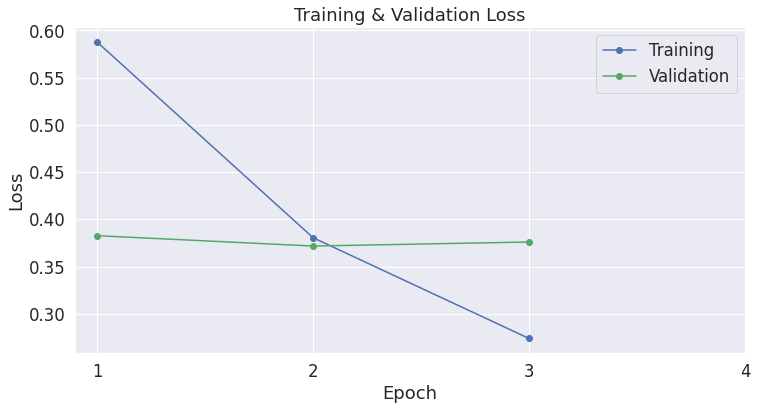

In [52]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [53]:
# posts = valid_x.values
# categories = valid_y.values
posts = valid_x
categories = valid_y

In [54]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [55]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 475 test sentences...
    DONE.


In [56]:
print(predictions[0],true_labels[0])

[[ 4.071025    0.6455151  -2.5438023  -2.3961136 ]
 [ 4.4020004   0.3040659  -2.4348478  -2.342598  ]
 [ 4.4975443   0.46557128 -2.4041107  -2.4024696 ]
 [ 3.6756544   1.2394006  -2.58248    -2.589711  ]
 [ 3.1920457   2.4315987  -2.6532192  -2.999734  ]
 [ 3.864484    1.1618338  -2.5666502  -2.835919  ]
 [ 4.289539    1.1265717  -2.5175567  -2.6631355 ]
 [ 4.3015327   0.6329232  -2.3247786  -2.5645065 ]
 [ 1.2594702   3.3216412  -2.40835    -2.1632197 ]
 [ 4.167192   -0.39152682 -1.7839669  -1.9591285 ]
 [ 4.370276    0.8659677  -2.7009006  -2.5919697 ]
 [ 3.8940725   0.9836284  -2.72088    -2.5111277 ]
 [ 3.2045863   1.6445718  -2.8445334  -2.6958463 ]
 [ 3.6955254   1.5767964  -2.7940385  -2.7577724 ]
 [ 3.4214916   2.1309576  -2.9816935  -2.8397632 ]
 [-0.41699484  3.7179573  -1.7409167  -1.6039004 ]] [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]


In [57]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
predicts = []
accurate = 0
total_len = 0
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    predicts.append(pred_labels_i)
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)

    matthews_set.append(matthews)
    for j in range(len(true_labels[i])):
        if true_labels[i][j] == pred_labels_i[j]:
            accurate+=1
        total_len+=1
print("Accuracy:",accurate/total_len)

Calculating Matthews Corr. Coef. for each batch...
Accuracy: 0.848421052631579


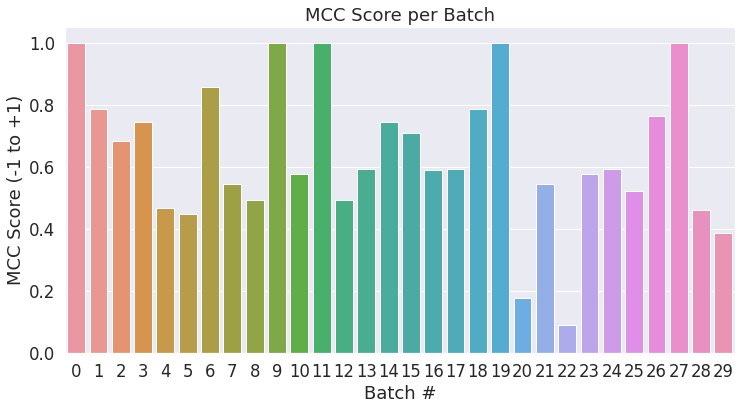

In [58]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()


In [59]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.628


In [60]:
accurate = 0
for (i,j) in zip(flat_predictions, flat_true_labels):
    if i==j:
        accurate += 1
accurate/len(flat_predictions)

0.848421052631579

In [61]:
from sklearn.metrics import f1_score
f1_score(flat_true_labels, flat_predictions, average='macro')

0.8137254901960784